# Check energyConsumption table
Getting the energyConsumption table in MySQL to determine if historical live data is correct enough.  
Checks:  
- hp energy consumption [0, 2500] Wh / hr, [0, 5000] for 8kW
- hp heat produced [-100, 8000] Wh / hr, [-100, 16000] for 8kW
- boiler heat produced [0, 37000] Wh / hr



In [1]:
import pandas as pd
import datetime
import pymysql
import os
from urllib.parse import urlparse

In [2]:
# get data from mysql or local
if os.environ['ENVIRONMENT'] == 'local':
    # load csv file
    df_energy = pd.read_csv('../data/20230918_energyConsumption.csv')
    df_hps = pd.read_csv('../data/20230918_hps.csv')

else:
    MYSQL_URL = os.environ['MYSQLPROD']
    parsed_mysql_url = urlparse(MYSQL_URL)

    try:
        connection = pymysql.connect(host=parsed_mysql_url.hostname,
                                    user=parsed_mysql_url.username,
                                    password=parsed_mysql_url.password,
                                    database=parsed_mysql_url.path[1:],
                                    port=parsed_mysql_url.port,
                                    autocommit=True)
        cursor = connection.cursor()
        if cursor.connection:
            # get energyConsumption
            cursor.execute('''SELECT * FROM energyConsumption''')
            fields = [field_md[0] for field_md in cursor.description]
            result = [dict(zip(fields,row)) for row in cursor.fetchall()]
            df_energy = pd.DataFrame(result)
            df_energy.to_csv('../data/20230918_energyConsumption.csv', index=False)
            
            # get cics and energy of hp
            cursor.execute('''SELECT id, installationId, numberOfHeatPumps FROM cic''')
            fields = [field_md[0] for field_md in cursor.description]
            result = [dict(zip(fields,row)) for row in cursor.fetchall()]
            df_hps = pd.DataFrame(result)
            df_hps.to_csv('../data/20230918_hps.csv', index=False)
    except:
        print("Error while connecting to MySQL")
    finally:
        cursor.close()
        connection.close()

    # convert to dataframe
   

    # dump data as csv
    # 

In [3]:
# merge data frames
df = pd.merge(df_energy, df_hps, how='left', 
              left_on='installationId', right_on='installationId')

# remove 0 values to find cliffs only and not canyon
df = df[df['hpElectric'] > 0]

# check for installationIds that could not be matched
print(len(df[df['id_y'].isnull()]['installationId'].unique()))

# calculate differences in counters
df['ts'] = pd.to_datetime(df['timestamp'])
df.sort_values(by=['installationId', 'ts'], inplace=True)
df['hpElectricDiff'] = df.groupby('installationId')['hpElectric'].diff()
df['hpHeatDiff'] = df.groupby('installationId')['hpHeat'].diff()
df['boilerHeatDiff'] = df.groupby('installationId')['boilerHeat'].diff()


17


In [4]:
# calculate differences per hour
df['timediff'] = df.groupby('installationId')['ts'].diff()
df['hpElectricDiffHr'] = df['hpElectricDiff'] / df['timediff'].dt.total_seconds()
df['hpHeatDiffHr'] = df['hpHeatDiff'] / df['timediff'].dt.total_seconds()
df['boilerHeatDiffHr'] = df['boilerHeatDiff'] / df['timediff'].dt.total_seconds()

In [5]:
# Find counters that violate the rules
print("electric < 0: ", len(df[df['hpElectricDiff'] < -10]['id_y'].unique()))
print("8kW electric > 5000: ", len(df[(df['hpElectricDiffHr'] > 5000) &
         (df['numberOfHeatPumps']==2)]['id_y'].unique()))
print("4kW electric > 2500: ", len(df[(df['hpElectricDiffHr'] > 2500) &
         (df['numberOfHeatPumps']!=2)]['id_y'].unique()))
df['check_1'] = df['hpElectricDiff'] < -10
df['check_2'] = (df['hpElectricDiffHr'] > 5000) & (df['numberOfHeatPumps']==2)
df['check_3'] = (df['hpElectricDiffHr'] > 2500) & (df['numberOfHeatPumps']!=2)

print("hpHeat < -100: ", len(df[df['hpHeatDiffHr'] < 0]['id_y'].unique()))
print("8kW electric > 16000: ", len(df[(df['hpHeatDiffHr'] > 16000) &
         (df['numberOfHeatPumps']==2)]['id_y'].unique()))
print("4kW heat > 8000: ", len(df[(df['hpHeatDiffHr'] > 8000) &
         (df['numberOfHeatPumps']!=2)]['id_y'].unique()))
df['check_4'] = df['hpHeatDiffHr'] < 0
df['check_5'] = (df['hpHeatDiffHr'] > 16000) & (df['numberOfHeatPumps']==2)
df['check_6'] = (df['hpHeatDiffHr'] > 8000) & (df['numberOfHeatPumps']!=2)


print("boilerHeat < 0: ", len(df[df['boilerHeatDiffHr'] < 0]['id_y'].unique()))
print("boilerHeat > 37000: ", len(df[(df['hpElectricDiffHr'] > 5000)]['id_y'].unique()))
df['check_7'] = df['boilerHeatDiffHr'] < 0
df['check_8'] = df['boilerHeatDiffHr'] > 37000

# count total cics not goed
print('Total nr. of cic incorrect: ', len(df[df[['check_1', 
                                                'check_2',
                                                'check_3',
                                                'check_4',
                                                'check_5',
                                                'check_6',
                                                'check_7',
                                                'check_8']].any(axis=1)]['id_y'].unique()))

electric < 0:  197
8kW electric > 5000:  0
4kW electric > 2500:  0
hpHeat < -100:  121
8kW electric > 16000:  0
4kW heat > 8000:  0
boilerHeat < 0:  78
boilerHeat > 37000:  0
Total nr. of cic incorrect:  240


Looking into what these errors look like and where they come from.

In [6]:
df[df['check_4']==True]['id_y'].unique()

array(['CIC-d26ddcf0-1926-58b2-b3e7-a83ff7103a68',
       'CIC-d8ba5839-b00e-50ad-ad34-86a2aa61d1d0',
       'CIC-89a7cb0d-b98d-5755-8fd8-d8500ed7b5c8',
       'CIC-170c0c31-16bc-5df0-9bbb-ff7568a6b2a0',
       'CIC-8c7cc037-bde9-5071-b9c8-446e6e7a46b8',
       'CIC-60ae389a-3750-5ff9-8952-38b70d2c9812',
       'CIC-f0d465aa-534b-59b9-95d1-8c535da88d5d',
       'CIC-eac84d52-11b6-5605-8ed2-e42c877727c2',
       'CIC-e0f7da62-52a0-566f-a343-3df80a0bb655',
       'CIC-7613e9c4-dd57-5c14-8a7d-9a539130d301',
       'CIC-9bec9a4a-ff78-5c92-a7a7-ed083696aaed',
       'CIC-3bc43f99-42db-55b1-aadf-c4bdccbae522',
       'CIC-d1136997-67cb-59f6-b4e8-469d04c450bf',
       'CIC-69603264-c52b-5a75-9541-79128dd5bdd7',
       'CIC-4a1b60b4-1ce2-52d0-801b-7a7491844fc8',
       'CIC-3a8267fb-e416-5727-9784-0babaa0b0b00',
       'CIC-46efeaa5-cd19-5df5-81f4-b03bfdafe23e',
       'CIC-719e86d9-7cb7-5e7c-80be-9a129253970b',
       'CIC-1d1ef1c1-52da-5b6d-ba7c-6ccb87618507',
       'CIC-36e247c6-4f6e-56eb-

In [27]:
len(df['id_y'].unique())

3119

<Axes: xlabel='ts'>

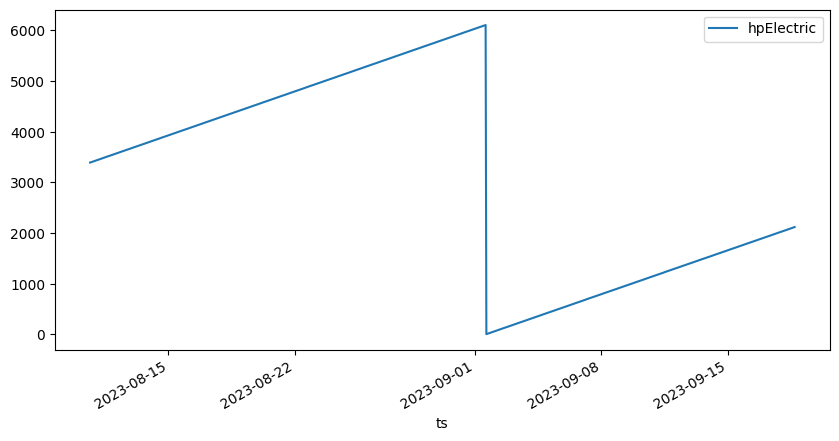

In [10]:
df[df['id_y']=='CIC-170c0c31-16bc-5df0-9bbb-ff7568a6b2a0'].plot(x='ts', y=['hpElectric'], figsize=(10,5))

In [20]:
df[(df['id_y']=='CIC-d8ba5839-b00e-50ad-ad34-86a2aa61d1d0')]['hpElectric'].describe()

count      940.000000
mean     13267.488298
std       3895.140141
min       7590.000000
25%       9989.500000
50%      12603.000000
75%      15903.500000
max      22626.000000
Name: hpElectric, dtype: float64

In [64]:
df[(df['id_y']=='CIC-8a59664f-f378-555a-a31a-88f268fb9556')]

,id_x,installationId,hpElectric,hpHeat,boilerHeat,timestamp,id_y,numberOfHeatPumps,ts,hpElectricDiff,hpHeatDiff,boilerHeatDiff,timediff,hpElectricDiffHr,hpHeatDiffHr,boilerHeatDiffHr
521,522,29,2322,0,0,2023-08-10 15:53:46,CIC-8a59664f-f378-555a-a31a-88f268fb9556,1.0,2023-08-10 15:53:46,NaN,NaN,NaN,NaT,NaN,NaN,NaN
2779,2780,29,2323,0,0,2023-08-10 16:00:02,CIC-8a59664f-f378-555a-a31a-88f268fb9556,1.0,2023-08-10 16:00:02,1.0,0.0,0.0,0 days 00:06:16,0.002660,0.0,0.0
8971,8972,29,2328,0,0,2023-08-10 17:00:13,CIC-8a59664f-f378-555a-a31a-88f268fb9556,1.0,2023-08-10 17:00:13,5.0,0.0,0.0,0 days 01:00:11,0.001385,0.0,0.0
11755,11756,29,2333,0,0,2023-08-10 18:00:07,CIC-8a59664f-f378-555a-a31a-88f268fb9556,1.0,2023-08-10 18:00:07,5.0,0.0,0.0,0 days 00:59:54,0.001391,0.0,0.0
15319,15320,29,2338,0,0,2023-08-10 19:00:14,CIC-8a59664f-f378-555a-a31a-88f268fb9556,1.0,2023-08-10 19:00:14,5.0,0.0,0.0,0 days 01:00:07,0.001386,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3200547,3200548,29,1366,0,0,2023-09-18 13:00:13,CIC-8a59664f-f378-555a-a31a-88f268fb9556,1.0,2023-09-18 13:00:13,5.0,0.0,0.0,0 days 01:00:10,0.001385,0.0,0.0
3203133,3203134,29,1371,0,0,2023-09-18 14:00:03,CIC-8a59664f-f378-555a-a31a-88f268fb9556,1.0,2023-09-18 14:00:03,5.0,0.0,0.0,0 days 00:59:50,0.001393,0.0,0.0
3210018,3210019,29,1376,0,0,2023-09-18 15:00:13,CIC-8a59664f-f378-555a-a31a-88f268fb9556,1.0,2023-09-18 15:00:13,5.0,0.0,0.0,0 days 01:00:10,0.001385,0.0,0.0
3213127,3213128,29,1381,0,0,2023-09-18 16:00:06,CIC-8a59664f-f378-555a-a31a-88f268fb9556,1.0,2023-09-18 16:00:06,5.0,0.0,0.0,0 days 00:59:53,0.001392,0.0,0.0


## check if every user has access to a set of energyConsumption counters

In [115]:
try:
	connection = pymysql.connect(host=parsed_mysql_url.hostname,
								user=parsed_mysql_url.username,
								password=parsed_mysql_url.password,
								database=parsed_mysql_url.path[1:],
								port=parsed_mysql_url.port,
								autocommit=True)
	cursor = connection.cursor()
	if cursor.connection:
		# get energyConsumption
		cursor.execute('''WITH cte1 as (
							SELECT DISTINCT(installationId), userId, cicId
							FROM userCic uc
							LEFT JOIN cic c on uc.cicId  = c.id
							WHERE installationId IS NOT NULL
							)
						, cte2 as (
							SELECT DISTINCT(installationId), MAX(hpElectric) as electric
							FROM energyConsumption ec
							GROUP BY installationId
						)
						SELECT * 
						FROM cte1 LEFT JOIN cte2 on cte1.installationId=cte2.installationId
						WHERE electric IS NULL
						''')
		fields = [field_md[0] for field_md in cursor.description]
		result = [dict(zip(fields,row)) for row in cursor.fetchall()]
		df_missing = pd.DataFrame(result)
		
except:
	print("Error while connecting to MySQL")
finally:
	cursor.close()
	connection.close()

In [100]:
def get_cic_stats_from_redis(redis_url):
    # Connect to Redis database
    parsed_url = urlparse(redis_url)
    r = redis.Redis(host=parsed_url.hostname,
                    port=parsed_url.port,
                    db=0,
                    password=parsed_url.password,
                    username=parsed_url.username)
    
    # get objects from redis
    redis_objects = r.mget(r.keys(pattern="cic:*CIC*lastStat*"))
    results = []
    for obj, key in zip(redis_objects, r.keys(pattern="cic:*CIC*lastStat*")):
        try:
            data = json.loads(obj.decode())
            data['cic'] = key.decode().split(':')[1]
            results.append(data)
        except:
            pass
    return results

In [109]:
import redis
import json
# get cic data from redis
REDIS_URL = os.getenv("REDISPROD")

redis_data = get_cic_stats_from_redis(REDIS_URL)

df_redis = pd.json_normalize(redis_data)


In [116]:
df_missing

,installationId,userId,cicId,electric
0,None,41bc10d3-2fff-4eb1-a3fc-46403c7166e9,CIC-f1116627-7738-591a-9b11-378534ed6526,None
1,None,ab0bdb45-28ba-4581-83a9-42798060979c,CIC-012d57a0-a443-58e4-a847-c59d0c9ed4f5,None
2,None,b79a0938-ebfb-418c-a650-3dac32b2498e,CIC-27b41d82-b9fe-5e25-ae3e-b9ca06940771,None
3,None,2284b559-54de-4dac-b7ab-1c1069fb4c29,CIC-869d7152-2c97-5d7c-9f25-3a483cf22321,None
4,None,5a5ac982-3bae-4700-8b72-f74b2d606490,CIC-4734d705-6b2a-5df4-8995-7a9012a1a564,None
...,...,...,...,...
112,None,f25c0aaf-ec5e-4fc3-a446-f28b2d5dc89a,CIC-e92050d7-db5a-55e8-9e0a-4a4aca76f022,None
113,None,3578e408-2289-47b6-92ee-34b3d771248a,CIC-ead30674-bbbc-53cb-a3db-d59ce93e2778,None
114,None,e201a5e5-a37a-40e9-ac45-22715f91c0b9,CIC-ead30674-bbbc-53cb-a3db-d59ce93e2778,None
115,None,62c95568-7fe6-46cd-ac6c-436cb6648e72,CIC-f56faea7-e3e6-596e-a734-db00ae008cce,None


In [113]:
for index, row in df_missing.iterrows():
    print(df_redis[df_redis['cic']==row['cicId']][['cic','system.quattBuild']], row['installationId'])

                                           cic system.quattBuild
4013  CIC-f1116627-7738-591a-9b11-378534ed6526             2.0.1 None
                                          cic system.quattBuild
807  CIC-012d57a0-a443-58e4-a847-c59d0c9ed4f5              None None
                                          cic system.quattBuild
739  CIC-27b41d82-b9fe-5e25-ae3e-b9ca06940771             2.0.3 None
                                           cic system.quattBuild
3087  CIC-869d7152-2c97-5d7c-9f25-3a483cf22321             2.0.3 None
                                          cic system.quattBuild
498  CIC-4734d705-6b2a-5df4-8995-7a9012a1a564             2.0.3 None
                                           cic system.quattBuild
3167  CIC-43217092-b786-5290-9638-6db0ae6af929             2.0.4 None
                                          cic system.quattBuild
246  CIC-dd3c658d-e9e8-5aa6-acb3-ce10c42c493c             2.0.3 None
                                          cic system.quattBuild

## checking at what hours energy is consumed

In [14]:
parsed_mysql_url = urlparse(os.environ['MYSQLDEV'])
connection = pymysql.connect(host=parsed_mysql_url.hostname,
                            user=parsed_mysql_url.username,
                            password=parsed_mysql_url.password,
                            database=parsed_mysql_url.path[1:],
                            port=parsed_mysql_url.port,
                            autocommit=True)
cursor = connection.cursor()
if cursor.connection:
    # get energyConsumption
    cursor.execute('''WITH cic_ids as (
                        SELECT cic_id
                        FROM `_cicsWithCorrectCounters` cwcc 
                        WHERE data_ready and NOT data_missing 
                        LIMIT 1000
                    )
                    SELECT
                        HOUR(convert_tz(`time`,'UTC','Europe/Amsterdam')) as hr,
                        SUM(hp1_heat_generated + COALESCE(hp2_heat_generated,0)) as e_tot,
                        AVG(hp1_heat_generated + COALESCE(hp2_heat_generated,0)) as e_avg,
                        COUNT(1) as nr_rows,
                        if(month(`time`) IN (11, 12, 1, 2, 3, 4), TRUE, FALSE) as winter
                    FROM cic_data cd 
                    WHERE cic_id in (SELECT * FROM cic_ids)
                    GROUP BY HOUR(convert_tz(`time`,'UTC','Europe/Amsterdam')), if(month(`time`) IN (11, 12, 1, 2, 3, 4), TRUE, FALSE)
                    ORDER BY HOUR(convert_tz(`time`,'UTC','Europe/Amsterdam'));
                    ''')
    fields = [field_md[0] for field_md in cursor.description]
    result = [dict(zip(fields,row)) for row in cursor.fetchall()]
    df = pd.DataFrame(result)

In [18]:
df

,hr,e_tot,e_avg,nr_rows,winter,check
0,0,872035.348661,10.4634615455,83431,0,True
1,0,6058805.159735,429.5197192496,14118,1,True
2,1,699322.527594,8.3965388067,83376,0,True
3,1,6029521.355714,427.8076738835,14106,1,True
4,2,849283.244345,10.1742248406,83563,0,True
5,2,7067758.770095,514.7675724760,13743,1,True
6,3,1066851.447430,12.8654122743,83014,0,True
7,3,8375716.170951,600.7542799420,13955,1,True
8,4,1335485.228606,16.1041533451,83016,0,True
9,4,9573168.215916,687.1352437494,13945,1,True


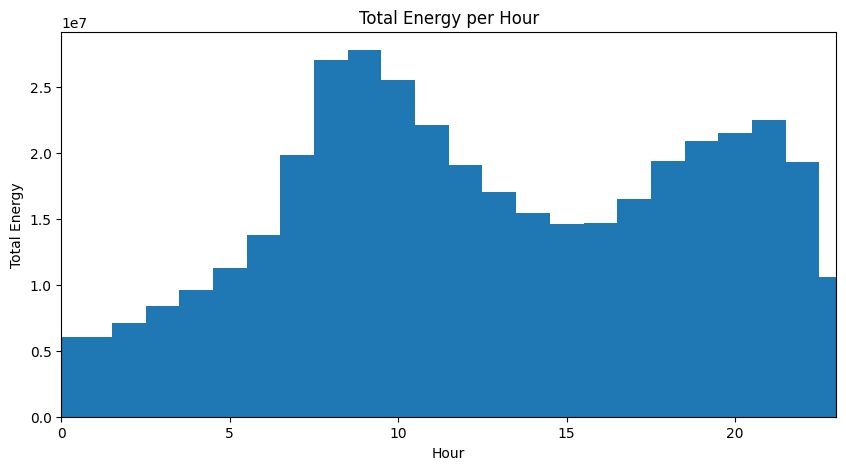

In [17]:
# # rename columns to hr, e_tot and e_avg
# df_missing.rename(columns={"HOUR(convert_tz(`time`,'UTC','Europe/Amsterdam'))":'hr',
#                            'SUM(hp1_heat_generated + COALESCE(hp2_heat_generated,0))':'e_tot',
#                            'AVG(hp1_heat_generated + COALESCE(hp2_heat_generated,0))':'e_avg',
#                            'nr_rows':'nr_rows'}, inplace=True)

# add column which checks if the hour is 7 or lower
df['check'] = df['hr'] <= 7

# Assuming df_missing is your DataFrame
plt.figure(figsize=(10, 5))
plt.bar(df['hr'], df['e_tot'], width=1.0, label=df['check'])  # Bar width is set to 1 hour

# Set x-axis range
plt.xlim(0, 23)

# Add labels and title
plt.xlabel('Hour')
plt.ylabel('Total Energy')
plt.title('Total Energy per Hour')

# Show the plot
plt.show()


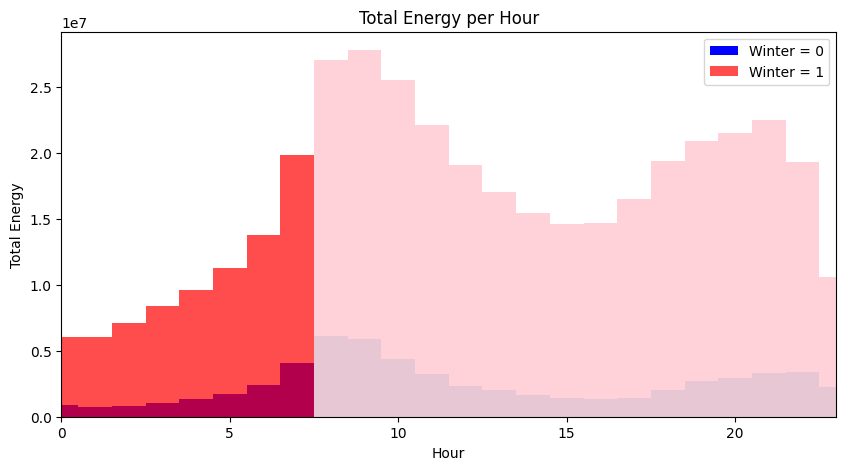

In [26]:
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
df['check'] = df['hr'] <= 7

# Separate data based on the 'winter' column
winter_0 = df[df['winter'] == 0]
winter_1 = df[df['winter'] == 1]

plt.figure(figsize=(10, 5))

# Plot for winter == 0
plt.bar(winter_0['hr'], winter_0['e_tot'], width=1.0, color=winter_0['check'].map({True: 'blue', False: 'lightblue'}), label='Winter = 0')

# Plot for winter == 1
plt.bar(winter_1['hr'], winter_1['e_tot'], width=1.0, color=winter_1['check'].map({True: 'red', False: 'pink'}), label='Winter = 1', alpha=0.7)

# Set x-axis range
plt.xlim(0, 23)

# Add labels and title
plt.xlabel('Hour')
plt.ylabel('Total Energy')
plt.title('Total Energy per Hour')

# Add legend
plt.legend()

# Show the plot
plt.show()


In [25]:
total_night = df[df['check']==True]['e_tot'].sum()
total_day = df[df['check']==False]['e_tot'].sum()
total = df['e_tot'].sum()
print('Total night: ', total_night)
print('Total day: ', total_day)
print('Total: ', total)
print('Percentage night: ', total_night/total)

# same calculation but then for winter==1
total_night = df[(df['check']==True) & (df['winter']==1)]['e_tot'].sum()
total_day = df[(df['check']==False) & (df['winter']==1)]['e_tot'].sum()
total = df[df['winter']==1]['e_tot'].sum()
print('Total night: ', total_night)
print('Total day: ', total_day)
print('Total: ', total)
print('Percentage night: ', total_night/total)

# same calculation but then for winter==0
total_night = df[(df['check']==True) & (df['winter']==0)]['e_tot'].sum()
total_day = df[(df['check']==False) & (df['winter']==0)]['e_tot'].sum()
total = df[df['winter']==0]['e_tot'].sum()
print('Total night: ', total_night)
print('Total day: ', total_day)
print('Total: ', total)
print('Percentage night: ', total_night/total)


Total night:  94988075.083386
Total day:  360484416.702259
Total:  455472491.785645
Percentage night:  0.2085484344202490271578299403
Total night:  81942047.132680
Total day:  314067386.132259
Total:  396009433.264939
Percentage night:  0.2069194323405396570821830999
Total night:  13046027.950706
Total day:  46417030.570000
Total:  59463058.520706
Percentage night:  0.2193971900413289670090589506


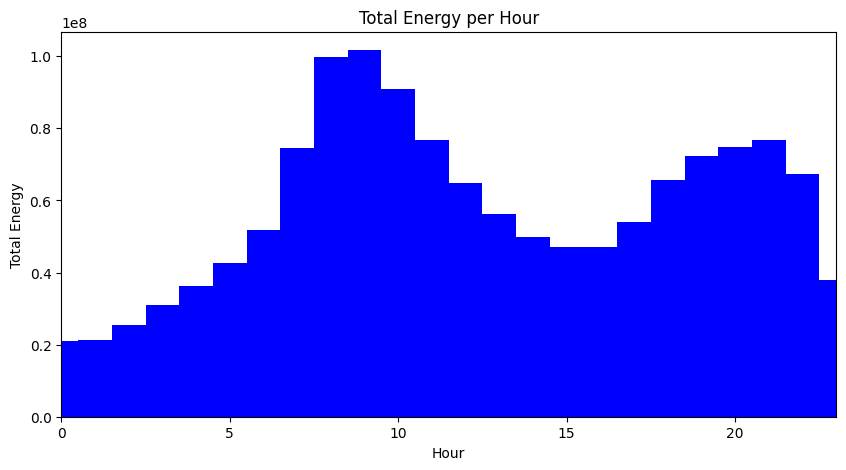

In [13]:
# convert columns to float
df_missing['hr'] = df_missing['hr'].astype(float)
df_missing['e_tot'] = df_missing['e_tot'].astype(float)
df_missing['e_avg'] = df_missing['e_avg'].astype(float)

import matplotlib.pyplot as plt
# Assuming df_missing is your DataFrame
plt.figure(figsize=(10, 5))
plt.bar(df_missing['hr'], df_missing['e_tot'], width=1.0, color='blue')  # Bar width is set to 1 hour

# Set x-axis range
plt.xlim(0, 23)

# Add labels and title
plt.xlabel('Hour')
plt.ylabel('Total Energy')
plt.title('Total Energy per Hour')

# Show the plot
plt.show()
